In [2]:
import math
import numpy as np
import pandas as pd
import scipy.stats as sc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime
import os
import plotly.express as px
px.defaults.template = 'plotly_dark'
import plotly.graph_objects as go
import nbformat
import re

pd.options.display.max_columns = 100

In [2]:
cwd = os.getcwd()

In [3]:
for file in os.listdir(cwd+"/data/doordash_shrayash"):
    print(file)

financials_simplified_transactions_us_2024-12-01_2025-05-13_PsL42_2025-05-14T18-24-19Z.csv
financials_detailed_transactions_us_2024-12-01_2025-05-13_PsL42_2025-05-14T18-24-19Z.csv
error_charges_adjustments_default_2024-12-01_2025-05-13_PsL42_2025-05-14T18-24-19Z.csv
financials_payout_summary_us_2024-12-01_2025-05-13_PsL42_2025-05-14T18-24-19Z.csv
financials_detailed_transactions_summarized_us_2024-12-01_2025-05-13_PsL42_2025-05-14T18-24-19Z.csv


In [13]:
transaction_dat = pd.read_csv(cwd+"/data/doordash_shrayash/financials_detailed_transactions_us_2024-12-01_2025-05-13_PsL42_2025-05-14T18-24-19Z.csv")
transaction_columns = [col.replace(" ","_").lower() for col in transaction_dat.columns]
transaction_dat.columns = transaction_columns
transaction_dat.head()


,timestamp_utc_time,timestamp_utc_date,timestamp_local_time,timestamp_local_date,payout_time,payout_date,store_id,business_id,store_name,merchant_store_id,transaction_type,transaction_id,doordash_order_id,merchant_delivery_id,external_id,description,final_order_status,currency,subtotal,subtotal_tax_passed_by_doordash_to_merchant,pre-adjusted_subtotal,pre-adjusted_tax_subtotal,commission,commission_tax,marketing_fees_(for_historical_reference_only)_|_(all_discounts_and_fees),marketing_fee_tax_(for_historical_reference_only)_|_(taxes_on_any_applicable_marketing_fees),total_tips,snap_ebt_discount,external_gift_card_credit_amount,credit,debit,doordash_transaction_id,payout_id,total_tax_remitted_by_doordash_to_tax_authorities,subtotal_for_tax,doordash_funded_subtotal_discount_amount_|_(for_historical_reference_only),merchant_funded_subtotal_discount_amount_|_(for_historical_reference_only),error_charge,adjustments_|_(for_historical_reference_only),other_merchant_fee,bottle_deposit_fee,bottle_deposit_fee_tax,printer_fee,tablet_fee,payment_processing_fee,delivery_order_fee,pickup_order_fee,customer_delivery_fee,customer_delivery_fee_tax,customer_small_order_fee,customer_small_order_fee_tax,staff_tip,courier_tip,flexible_fulfillment_fee,subtotal_tax_remitted_by_doordash_to_tax_authorities,customer_fee_tax_remitted_by_doordash_to_tax_authorities,customer_discounts_from_marketing_|_(funded_by_you),customer_discounts_from_marketing_|_(funded_by_doordash),customer_discounts_from_marketing_|_(funded_by_a_third-party),marketing_fees_|_(including_any_applicable_taxes),doordash_marketing_credit,third-party_contribution,adjustments
0,11:26:22,2024-12-01,06:26:22,2024-12-01,2024-12-05 10:25:15.000606000,2024-12-05,787703,252381,Pizza Palace (Reisterstown),NaN,FEE,NaN,NaN,NaN,NaN,Tablet fee,Delivered,USD,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,3.0,11841898541,444854366.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20:09:52,2024-12-01,15:09:52,2024-12-01,2024-12-05 10:25:15.000606000,2024-12-05,787703,252381,Pizza Palace (Reisterstown),NaN,DEMANDGEN_DELIVERY,07b0bb53-297e-3001-9372-70cd2d70b2c2,"=""2D70B2C2""",NaN,NaN,Order Received Time: 2024-12-01 14:04:49.79510...,Delivered,USD,31.98,1.64,0.00,0.0,3.26,0.0,5.78,0.0,5.5,0.0,0.0,30.08,0.0,11844525161,444854366.0,0.0,27.19,8.01,4.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.5,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21:19:31,2024-12-01,16:19:31,2024-12-01,2024-12-05 10:25:15.000606000,2024-12-05,787703,252381,Pizza Palace (Reisterstown),NaN,DEMANDGEN_DELIVERY,2c317c06-8788-3001-bdc4-f3fc3f8f0ab6,"=""3F8F0AB6""",NaN,NaN,Order Received Time: 2024-12-01 15:09:16.41350...,Delivered,USD,37.48,1.92,31.98,0.0,3.82,0.0,6.61,0.0,5.5,0.0,0.0,34.47,0.0,11845157268,444854366.0,0.0,31.86,9.38,5.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.5,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23:04:25,2024-12-01,18:04:25,2024-12-01,2024-12-05 10:25:15.000606000,2024-12-05,787703,252381,Pizza Palace (Reisterstown),NaN,DEMANDGEN_DELIVERY,bacfab2c-00aa-3001-aa74-f589e34ed367,"=""E34ED367""",NaN,NaN,Order Received Time: 2024-12-01 16:55:22.64215...,Delivered,USD,19.74,1.01,16.99,0.0,2.01,0.0,3.95,0.0,4.5,0.0,0.0,19.29,0.0,11846264028,444854366.0,0.0,16.78,4.94,2.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18:58:55,2024-12-02,13:58:55,2024-12-02,2024-12-06 11:19:37.463894000,2024-12-06,787703,252381,Pizza Palace (Reisterstown),NaN,DEMANDGEN_DELIVERY,fb6b48e6-c19f-3001-827b-f83a52a64690,"=""52A64690""",NaN,NaN,Order Received Time: 2024-12-02 13:33:28.38602...,Picked Up,USD,15.99,0.82,0.00,0.0,0.82,0.0,3.38,0.0,0.0,0.0,0.0,12.61,0.0,11852727543,444872047.0,0.0,13.60,4.01,2.39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
transaction_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181 entries, 0 to 1180
Data columns (total 63 columns):
 #   Column                                                                                        Non-Null Count  Dtype  
---  ------                                                                                        --------------  -----  
 0   timestamp_utc_time                                                                            1181 non-null   object 
 1   timestamp_utc_date                                                                            1181 non-null   object 
 2   timestamp_local_time                                                                          1181 non-null   object 
 3   timestamp_local_date                                                                          1181 non-null   object 
 4   payout_time                                                                                   1156 non-null   object 
 5   payout_date                

In [15]:
# Time Features
transaction_dat['timestamp_local_date'] = pd.to_datetime(transaction_dat['timestamp_local_date'])
transaction_dat['ts_order'] = pd.to_datetime(transaction_dat['timestamp_local_date'].astype('str') + " " + transaction_dat['timestamp_local_time'])
transaction_dat['hour'] = transaction_dat['ts_order'].dt.hour
transaction_dat['month'] = transaction_dat['ts_order'].dt.to_period('1M').dt.to_timestamp()
transaction_dat['time_of_day'] = np.where(transaction_dat['hour']< 15,'lunch',np.where(transaction_dat['hour']<18,'recess','dinner'))
transaction_dat['day_type'] = np.where(transaction_dat['ts_order'].dt.day_name().isin(['Saturday','Sunday']),"Weekend","Weekday")

# Order time features
# Use regular expression to extract the timestamps
transaction_dat["received_time"] = transaction_dat["description"].str.extract(r"Order Received Time:\s*([\d\-:\. ]+)")
transaction_dat["pickup_time"] = transaction_dat["description"].str.extract(r"Order Pickup Time:\s*([\d\-:\. ]+)")
transaction_dat["received_time"] = pd.to_datetime(transaction_dat["received_time"])
transaction_dat["pickup_time"] = pd.to_datetime(transaction_dat["pickup_time"])
transaction_dat["time_to_pickup_mins"] = (transaction_dat['pickup_time'] - transaction_dat['received_time']).dt.seconds / (60)



In [16]:
transaction_dat['time_of_day'].value_counts(normalize = True)

time_of_day
dinner    0.646909
lunch     0.178662
recess    0.174428
Name: proportion, dtype: float64

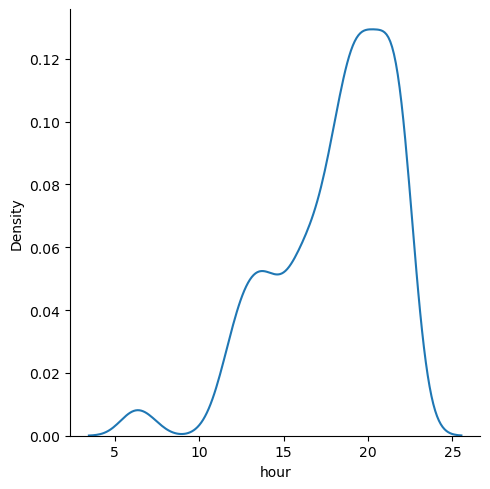

In [17]:
sns.displot(transaction_dat['hour'],kind = 'kde')

In [18]:
transaction_dat.sort_values('ts_order',ascending = True)
transaction_dat.head()

,timestamp_utc_time,timestamp_utc_date,timestamp_local_time,timestamp_local_date,payout_time,payout_date,store_id,business_id,store_name,merchant_store_id,transaction_type,transaction_id,doordash_order_id,merchant_delivery_id,external_id,description,final_order_status,currency,subtotal,subtotal_tax_passed_by_doordash_to_merchant,pre-adjusted_subtotal,pre-adjusted_tax_subtotal,commission,commission_tax,marketing_fees_(for_historical_reference_only)_|_(all_discounts_and_fees),marketing_fee_tax_(for_historical_reference_only)_|_(taxes_on_any_applicable_marketing_fees),total_tips,snap_ebt_discount,external_gift_card_credit_amount,credit,debit,doordash_transaction_id,payout_id,total_tax_remitted_by_doordash_to_tax_authorities,subtotal_for_tax,doordash_funded_subtotal_discount_amount_|_(for_historical_reference_only),merchant_funded_subtotal_discount_amount_|_(for_historical_reference_only),error_charge,adjustments_|_(for_historical_reference_only),other_merchant_fee,bottle_deposit_fee,bottle_deposit_fee_tax,printer_fee,tablet_fee,payment_processing_fee,delivery_order_fee,pickup_order_fee,customer_delivery_fee,customer_delivery_fee_tax,customer_small_order_fee,customer_small_order_fee_tax,staff_tip,courier_tip,flexible_fulfillment_fee,subtotal_tax_remitted_by_doordash_to_tax_authorities,customer_fee_tax_remitted_by_doordash_to_tax_authorities,customer_discounts_from_marketing_|_(funded_by_you),customer_discounts_from_marketing_|_(funded_by_doordash),customer_discounts_from_marketing_|_(funded_by_a_third-party),marketing_fees_|_(including_any_applicable_taxes),doordash_marketing_credit,third-party_contribution,adjustments,ts_order,hour,month,time_of_day,day_type,received_time,pickup_time,time_to_pickup_mins
0,11:26:22,2024-12-01,06:26:22,2024-12-01,2024-12-05 10:25:15.000606000,2024-12-05,787703,252381,Pizza Palace (Reisterstown),NaN,FEE,NaN,NaN,NaN,NaN,Tablet fee,Delivered,USD,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,3.0,11841898541,444854366.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-12-01 06:26:22,6,2024-12-01,lunch,Weekend,NaT,NaT,NaN
1,20:09:52,2024-12-01,15:09:52,2024-12-01,2024-12-05 10:25:15.000606000,2024-12-05,787703,252381,Pizza Palace (Reisterstown),NaN,DEMANDGEN_DELIVERY,07b0bb53-297e-3001-9372-70cd2d70b2c2,"=""2D70B2C2""",NaN,NaN,Order Received Time: 2024-12-01 14:04:49.79510...,Delivered,USD,31.98,1.64,0.00,0.0,3.26,0.0,5.78,0.0,5.5,0.0,0.0,30.08,0.0,11844525161,444854366.0,0.0,27.19,8.01,4.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.5,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-12-01 15:09:52,15,2024-12-01,recess,Weekend,2024-12-01 14:04:49.795104,2024-12-01 15:09:51.000,65.016667
2,21:19:31,2024-12-01,16:19:31,2024-12-01,2024-12-05 10:25:15.000606000,2024-12-05,787703,252381,Pizza Palace (Reisterstown),NaN,DEMANDGEN_DELIVERY,2c317c06-8788-3001-bdc4-f3fc3f8f0ab6,"=""3F8F0AB6""",NaN,NaN,Order Received Time: 2024-12-01 15:09:16.41350...,Delivered,USD,37.48,1.92,31.98,0.0,3.82,0.0,6.61,0.0,5.5,0.0,0.0,34.47,0.0,11845157268,444854366.0,0.0,31.86,9.38,5.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.5,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-12-01 16:19:31,16,2024-12-01,recess,Weekend,2024-12-01 15:09:16.413505,2024-12-01 16:19:30.000,70.216667
3,23:04:25,2024-12-01,18:04:25,2024-12-01,2024-12-05 10:25:15.000606000,2024-12-05,787703,252381,Pizza Palace (Reisterstown),NaN,DEMANDGEN_DELIVERY,bacfab2c-00aa-3001-aa74-f589e34ed367,"=""E34ED367""",NaN,NaN,Order Received Time: 2024-12-01 16:55:22.64215...,Delivered,USD,19.74,1.01,16.99,0.0,2.01,0.0,3.95,0.0,4.5,0.0,0.0,19.29,0.0,11846264028,444854366.0,0.0,16.78,4.94,2.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-12-01 18:04:25,18,2024-12-01,dinner,Weekend,2024-12-01 16:55:22.642157,2024-12-01 18:04:24.000,69.016667
4,18:58:55,2024-12-02,13:58:55,2024-12-02,2024-12-06 11:1

In [19]:
transaction_dat['transaction_type'].value_counts(normalize = True)

transaction_type
DEMANDGEN_DELIVERY    0.726503
AD_FEE                0.243014
FEE                   0.020322
ERROR_CHARGE          0.010161
Name: proportion, dtype: float64

In [20]:
total_earned = transaction_dat.groupby(['timestamp_local_date','transaction_type']).agg(sales = ('transaction_type','count'),earned_amt = ('credit','sum')).reset_index()
total_earned[total_earned.transaction_type.str.contains("DEMAND")]
total_earned['month'] = total_earned['timestamp_local_date'].dt.to_period("1M")
total_earned['weekday'] = total_earned['timestamp_local_date'].dt.day_name()
total_earned['day_type'] = np.where(total_earned['weekday'].isin(['Saturday','Sunday']),'weekend','weekday')
total_earned.head()

,timestamp_local_date,transaction_type,sales,earned_amt,month,weekday,day_type
0,2024-12-01,DEMANDGEN_DELIVERY,3,83.84,2024-12,Sunday,weekend
1,2024-12-01,FEE,1,0.00,2024-12,Sunday,weekend
2,2024-12-02,DEMANDGEN_DELIVERY,5,124.32,2024-12,Monday,weekday
3,2024-12-03,AD_FEE,2,0.00,2024-12,Tuesday,weekday
4,2024-12-03,DEMANDGEN_DELIVERY,3,87.25,2024-12,Tuesday,weekday


In [21]:
# Plotly plots

filtered_earning_dat = total_earned[total_earned.transaction_type.str.contains("DEMAND")]
fig = px.scatter(filtered_earning_dat, x = 'timestamp_local_date', y = 'earned_amt',color = 'day_type',trendline='lowess')
fig.add_trace(go.Scatter(x = filtered_earning_dat['timestamp_local_date'],y = filtered_earning_dat['earned_amt']))
fig.show()

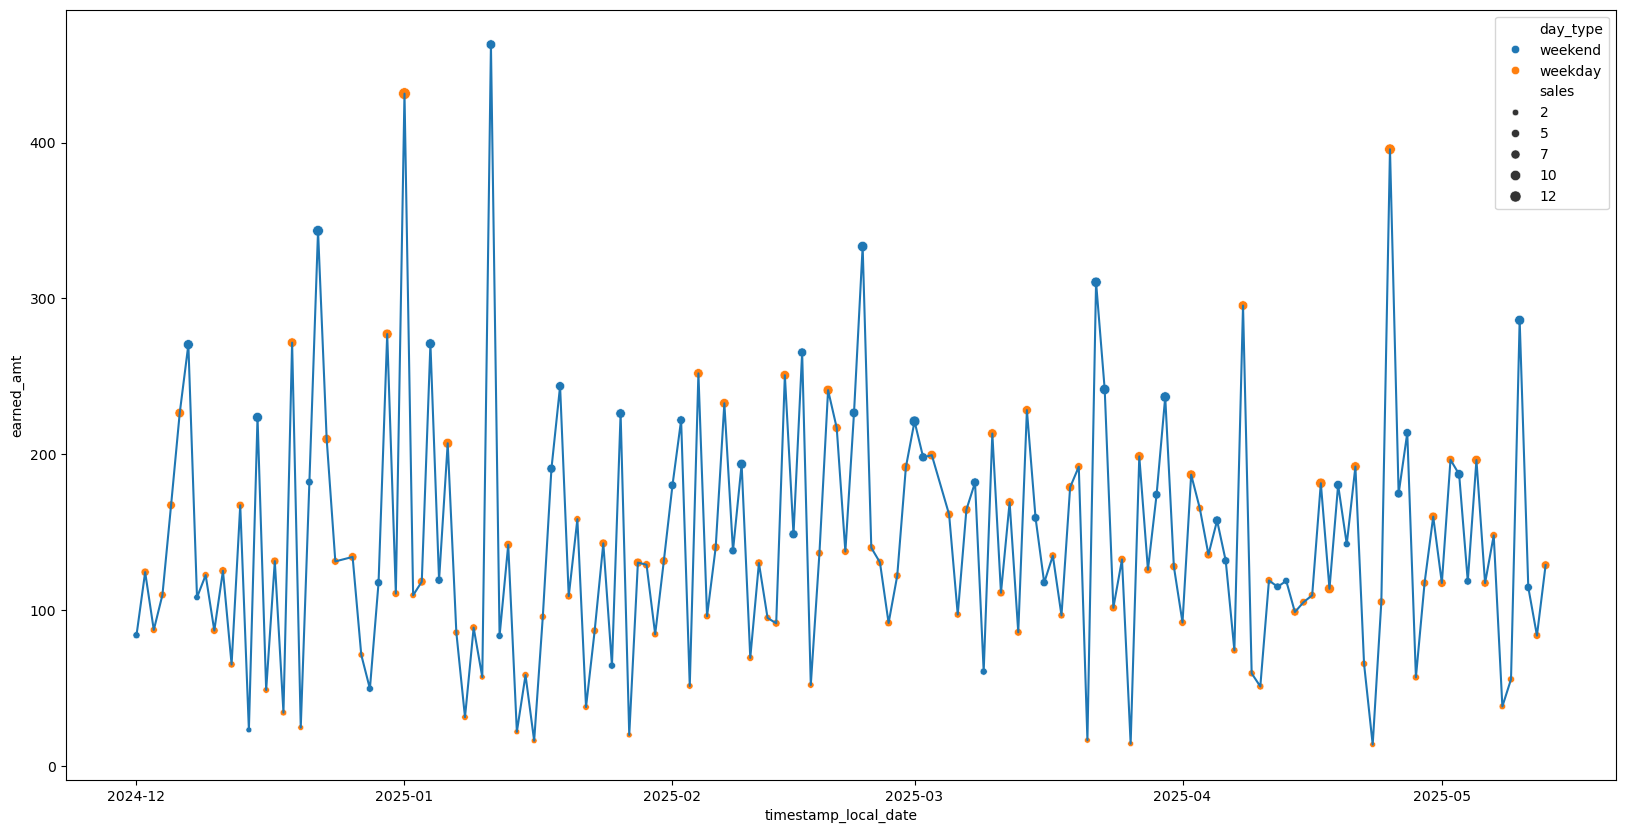

In [22]:
# Doordash sales over time

fig,ax = plt.subplots(figsize = (20,10))

sns.lineplot(total_earned[total_earned.transaction_type.str.contains("DEMAND")], x = 'timestamp_local_date', y= 'earned_amt')
sns.scatterplot(total_earned[total_earned.transaction_type.str.contains("DEMAND")], x = 'timestamp_local_date', y= 'earned_amt',size = 'sales',hue = 'day_type')
plt.show()

In [23]:
#Monthly earnings
monthly_rev = transaction_dat.groupby(['month','transaction_type']).agg(total = ("credit","sum")).reset_index()
monthly_rev[monthly_rev.transaction_type.str.contains("DEMAND")]

,month,transaction_type,total
1,2024-12-01,DEMANDGEN_DELIVERY,4127.51
5,2025-01-01,DEMANDGEN_DELIVERY,4153.22
9,2025-02-01,DEMANDGEN_DELIVERY,4575.77
12,2025-03-01,DEMANDGEN_DELIVERY,4649.51
15,2025-04-01,DEMANDGEN_DELIVERY,4126.65
18,2025-05-01,DEMANDGEN_DELIVERY,1787.33


In [24]:
#hourly activity
hourly_sales = transaction_dat.groupby(['hour','transaction_type']).agg(sales= ("transaction_type","count"),total = ("credit","sum")).reset_index()
hourly_sales[hourly_sales.transaction_type == 'DEMANDGEN_DELIVERY'].sort_values('sales',ascending = False)

,hour,transaction_type,sales,total
28,22,DEMANDGEN_DELIVERY,141,3680.55
20,19,DEMANDGEN_DELIVERY,118,3359.31
25,21,DEMANDGEN_DELIVERY,115,2917.95
22,20,DEMANDGEN_DELIVERY,112,3391.10
18,18,DEMANDGEN_DELIVERY,79,2437.97
16,17,DEMANDGEN_DELIVERY,57,1526.84
7,13,DEMANDGEN_DELIVERY,52,1173.34
14,16,DEMANDGEN_DELIVERY,47,1320.11
9,14,DEMANDGEN_DELIVERY,46,1077.25
12,15,DEMANDGEN_DELIVERY,39,1077.98


In [25]:
hourly_sales[hourly_sales.transaction_type == 'DEMANDGEN_DELIVERY'].shape

(13, 4)

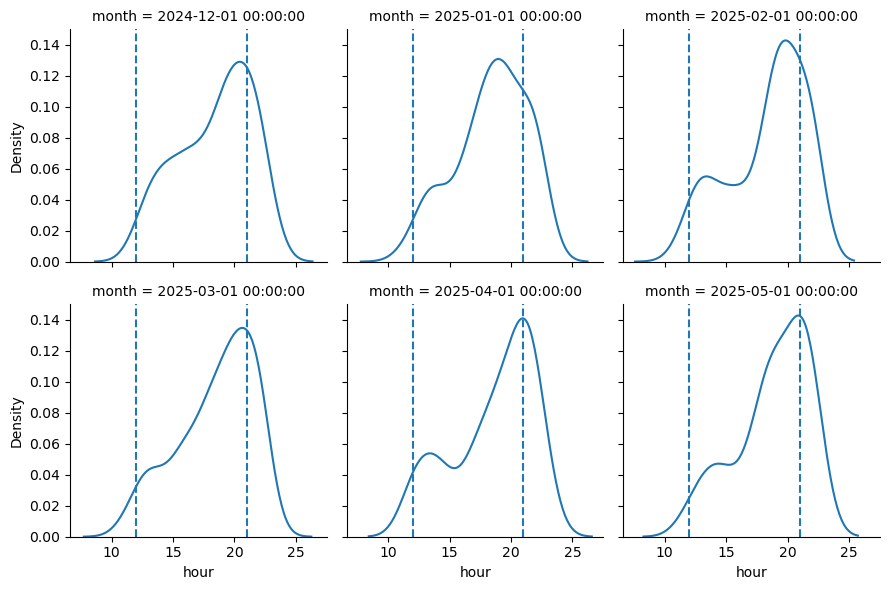

In [26]:
g = sns.FacetGrid(transaction_dat[transaction_dat.transaction_type == 'DEMANDGEN_DELIVERY'],col = 'month',col_wrap = 3)
g.map(sns.kdeplot,'hour')
x1, x2 = 12, 21
for ax in g.axes.flat:
    ax.axvline(x = x1,linestyle = '--')
    ax.axvline(x = x2,linestyle = '--')
plt.show()

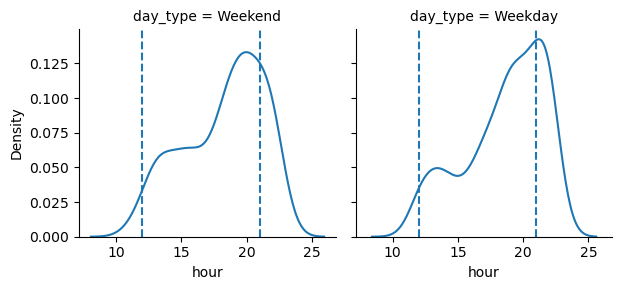

In [27]:
g = sns.FacetGrid(transaction_dat[transaction_dat.transaction_type == 'DEMANDGEN_DELIVERY'],col = 'day_type',col_wrap = 3)
g.map(sns.kdeplot,'hour')
x1, x2 = 12, 21
for ax in g.axes.flat:
    ax.axvline(x = x1,linestyle = '--')
    ax.axvline(x = x2,linestyle = '--')
plt.show()

In [28]:
transaction_dat.dtypes

timestamp_utc_time              object
timestamp_utc_date              object
timestamp_local_time            object
timestamp_local_date    datetime64[ns]
payout_time                     object
                             ...      
time_of_day                     object
day_type                        object
received_time           datetime64[ns]
pickup_time             datetime64[ns]
time_to_pickup_mins            float64
Length: 71, dtype: object

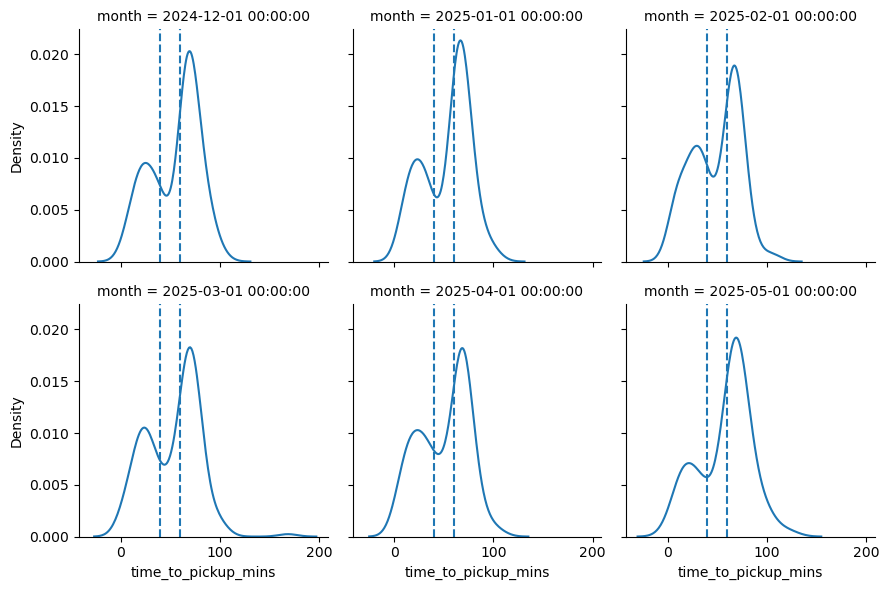

In [29]:
g = sns.FacetGrid(transaction_dat[(transaction_dat.transaction_type == 'DEMANDGEN_DELIVERY') & (transaction_dat["time_to_pickup_mins"] < 200)],col = 'month',col_wrap = 3)
g.map(sns.kdeplot,'time_to_pickup_mins')
x1, x2 = 40, 60
for ax in g.axes.flat:
    ax.axvline(x = x1,linestyle = '--')
    ax.axvline(x = x2,linestyle = '--')
plt.show()


In [30]:
# Some orders before 40 mins but a lot after 60 mins

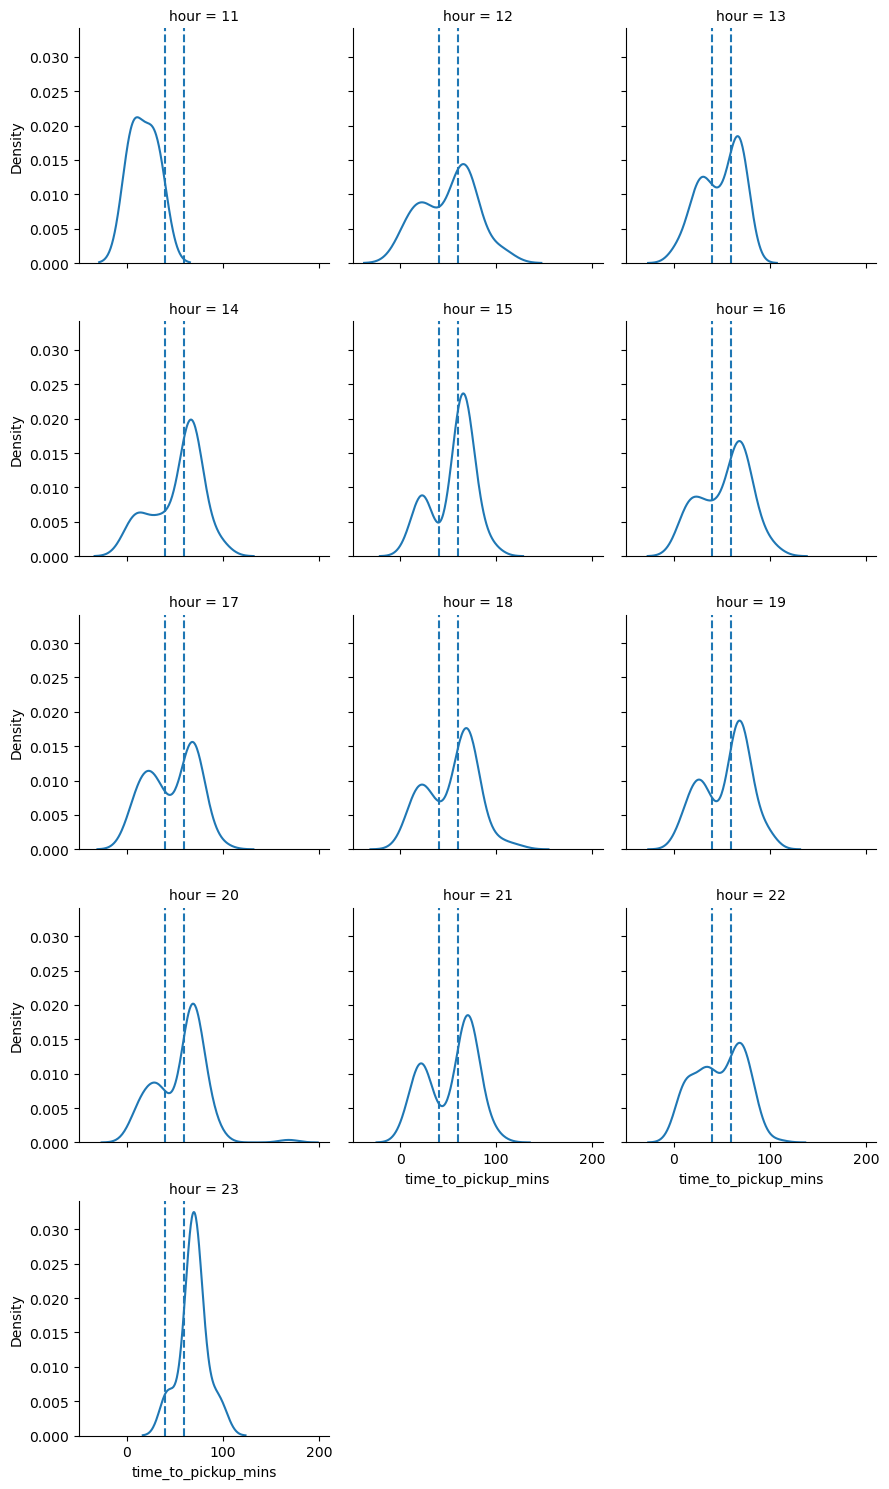

In [31]:
# Check on an hour level
# Does Busyness of the store define
g = sns.FacetGrid(transaction_dat[(transaction_dat.transaction_type == 'DEMANDGEN_DELIVERY') & (transaction_dat["time_to_pickup_mins"] < 200)],col = 'hour',col_wrap = 3)
g.map(sns.kdeplot,'time_to_pickup_mins')
x1, x2 = 40, 60
for ax in g.axes.flat:
    ax.axvline(x = x1,linestyle = '--')
    ax.axvline(x = x2,linestyle = '--')
plt.show()

In [32]:
# Are doordash drivers taking long to come?
# This can cause issues with customers perception of the food

In [33]:
transaction_dat['month'].dtypes

dtype('<M8[ns]')

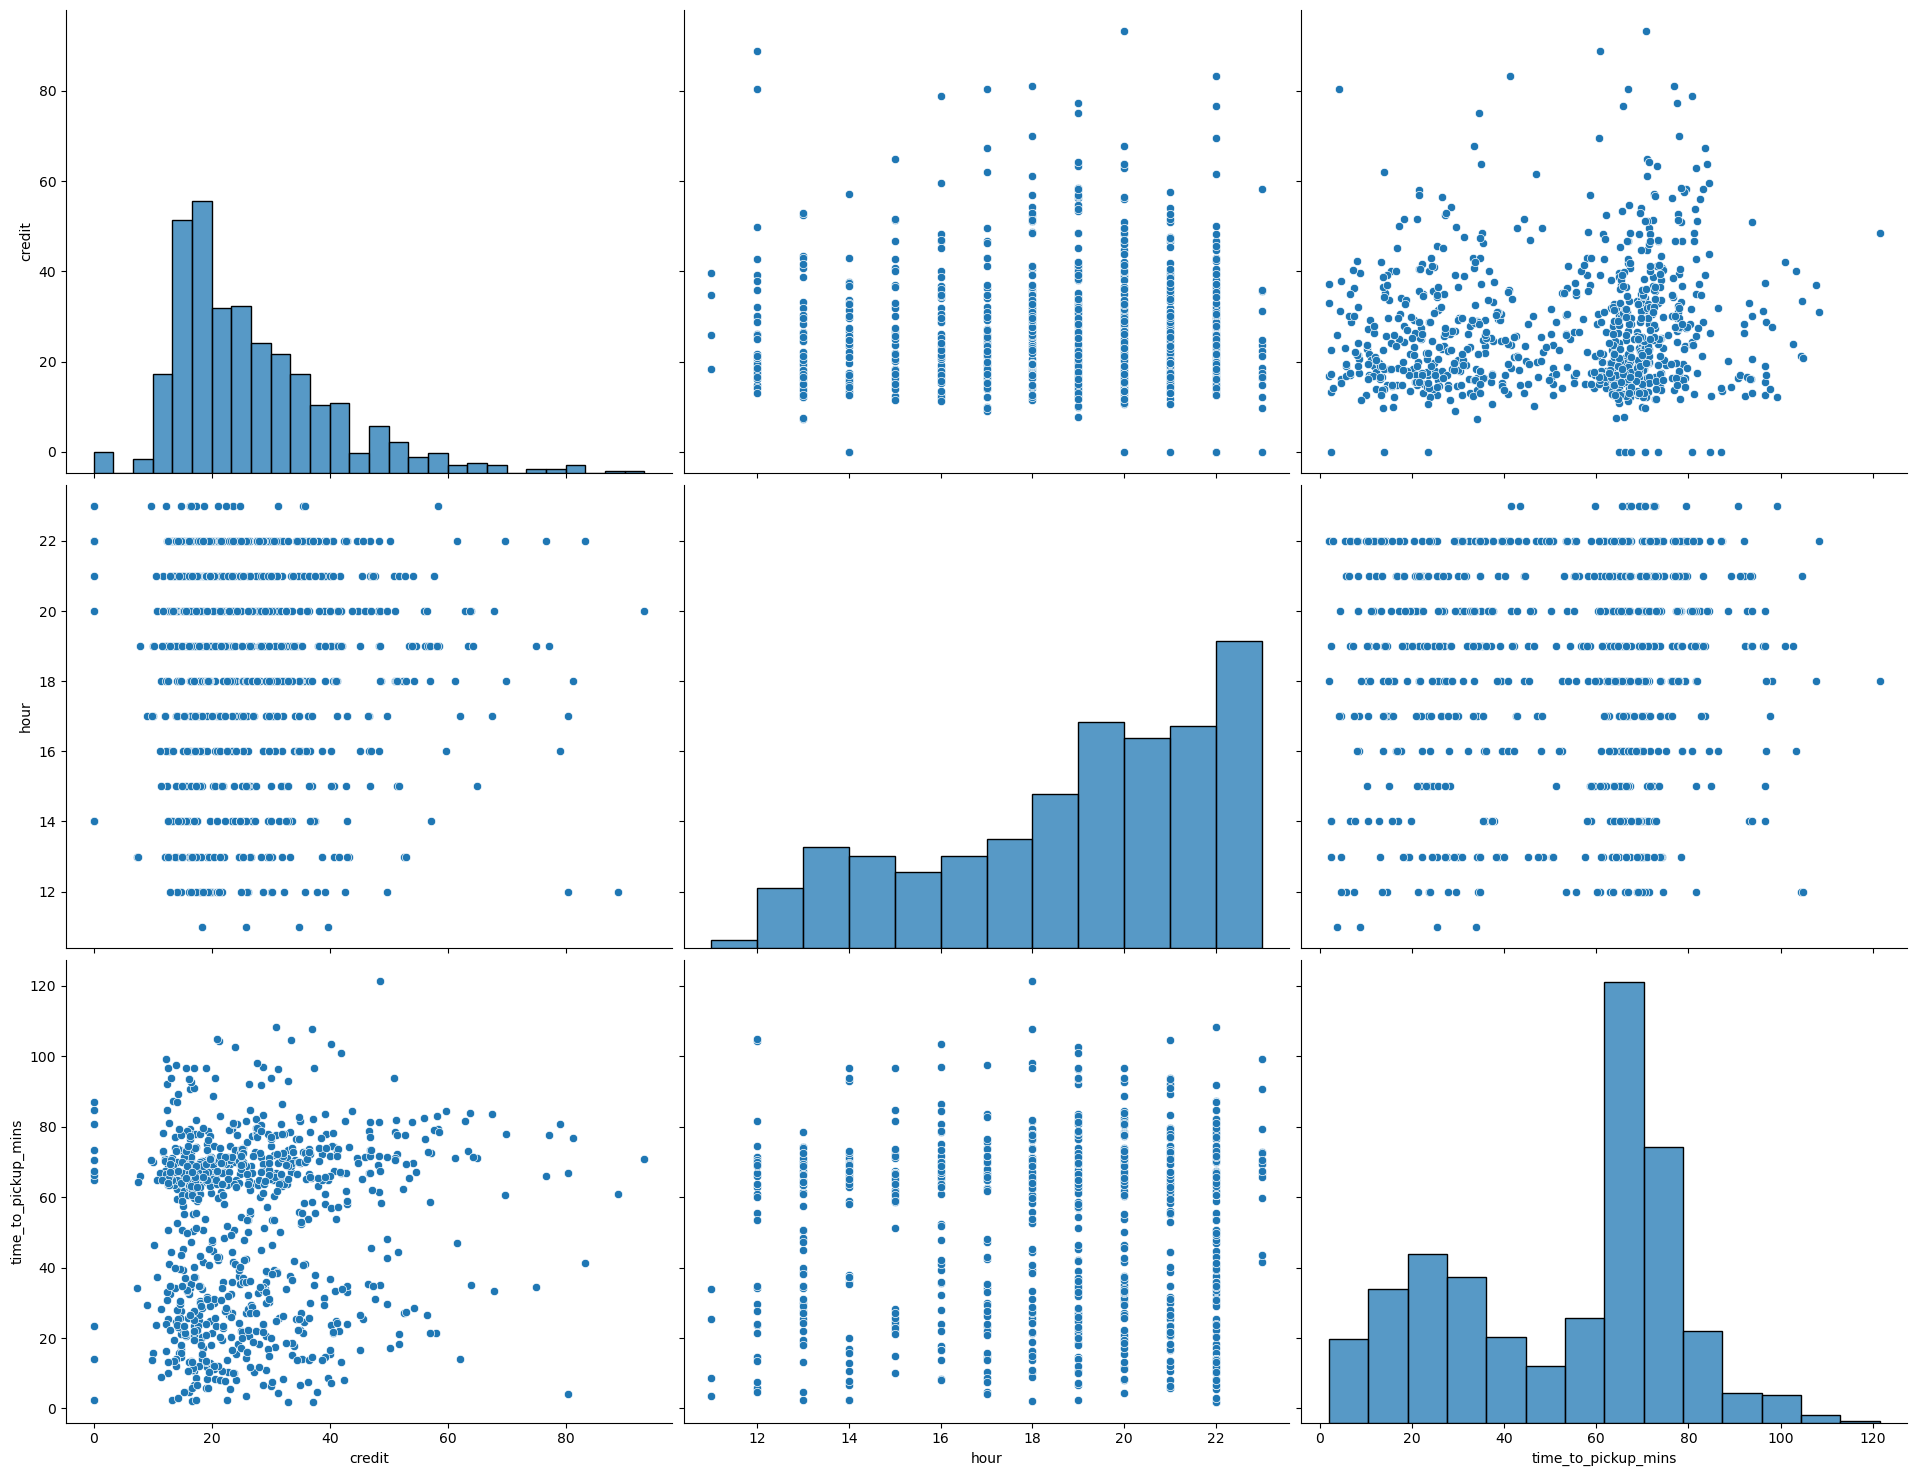

In [34]:
sns.pairplot(transaction_dat[(transaction_dat['credit'] < 100) & (transaction_dat['time_to_pickup_mins']< 130)] [['credit','hour','month','time_to_pickup_mins']],height= 5 ,aspect = 1.3)

In [35]:
# Some variablity in order types infered from spread of credit across hours
# Average orders ~15-20$ Net credit
# time to pickup seems to have 2 groups as was seen by the density plots as well, but not defined by hour/credit

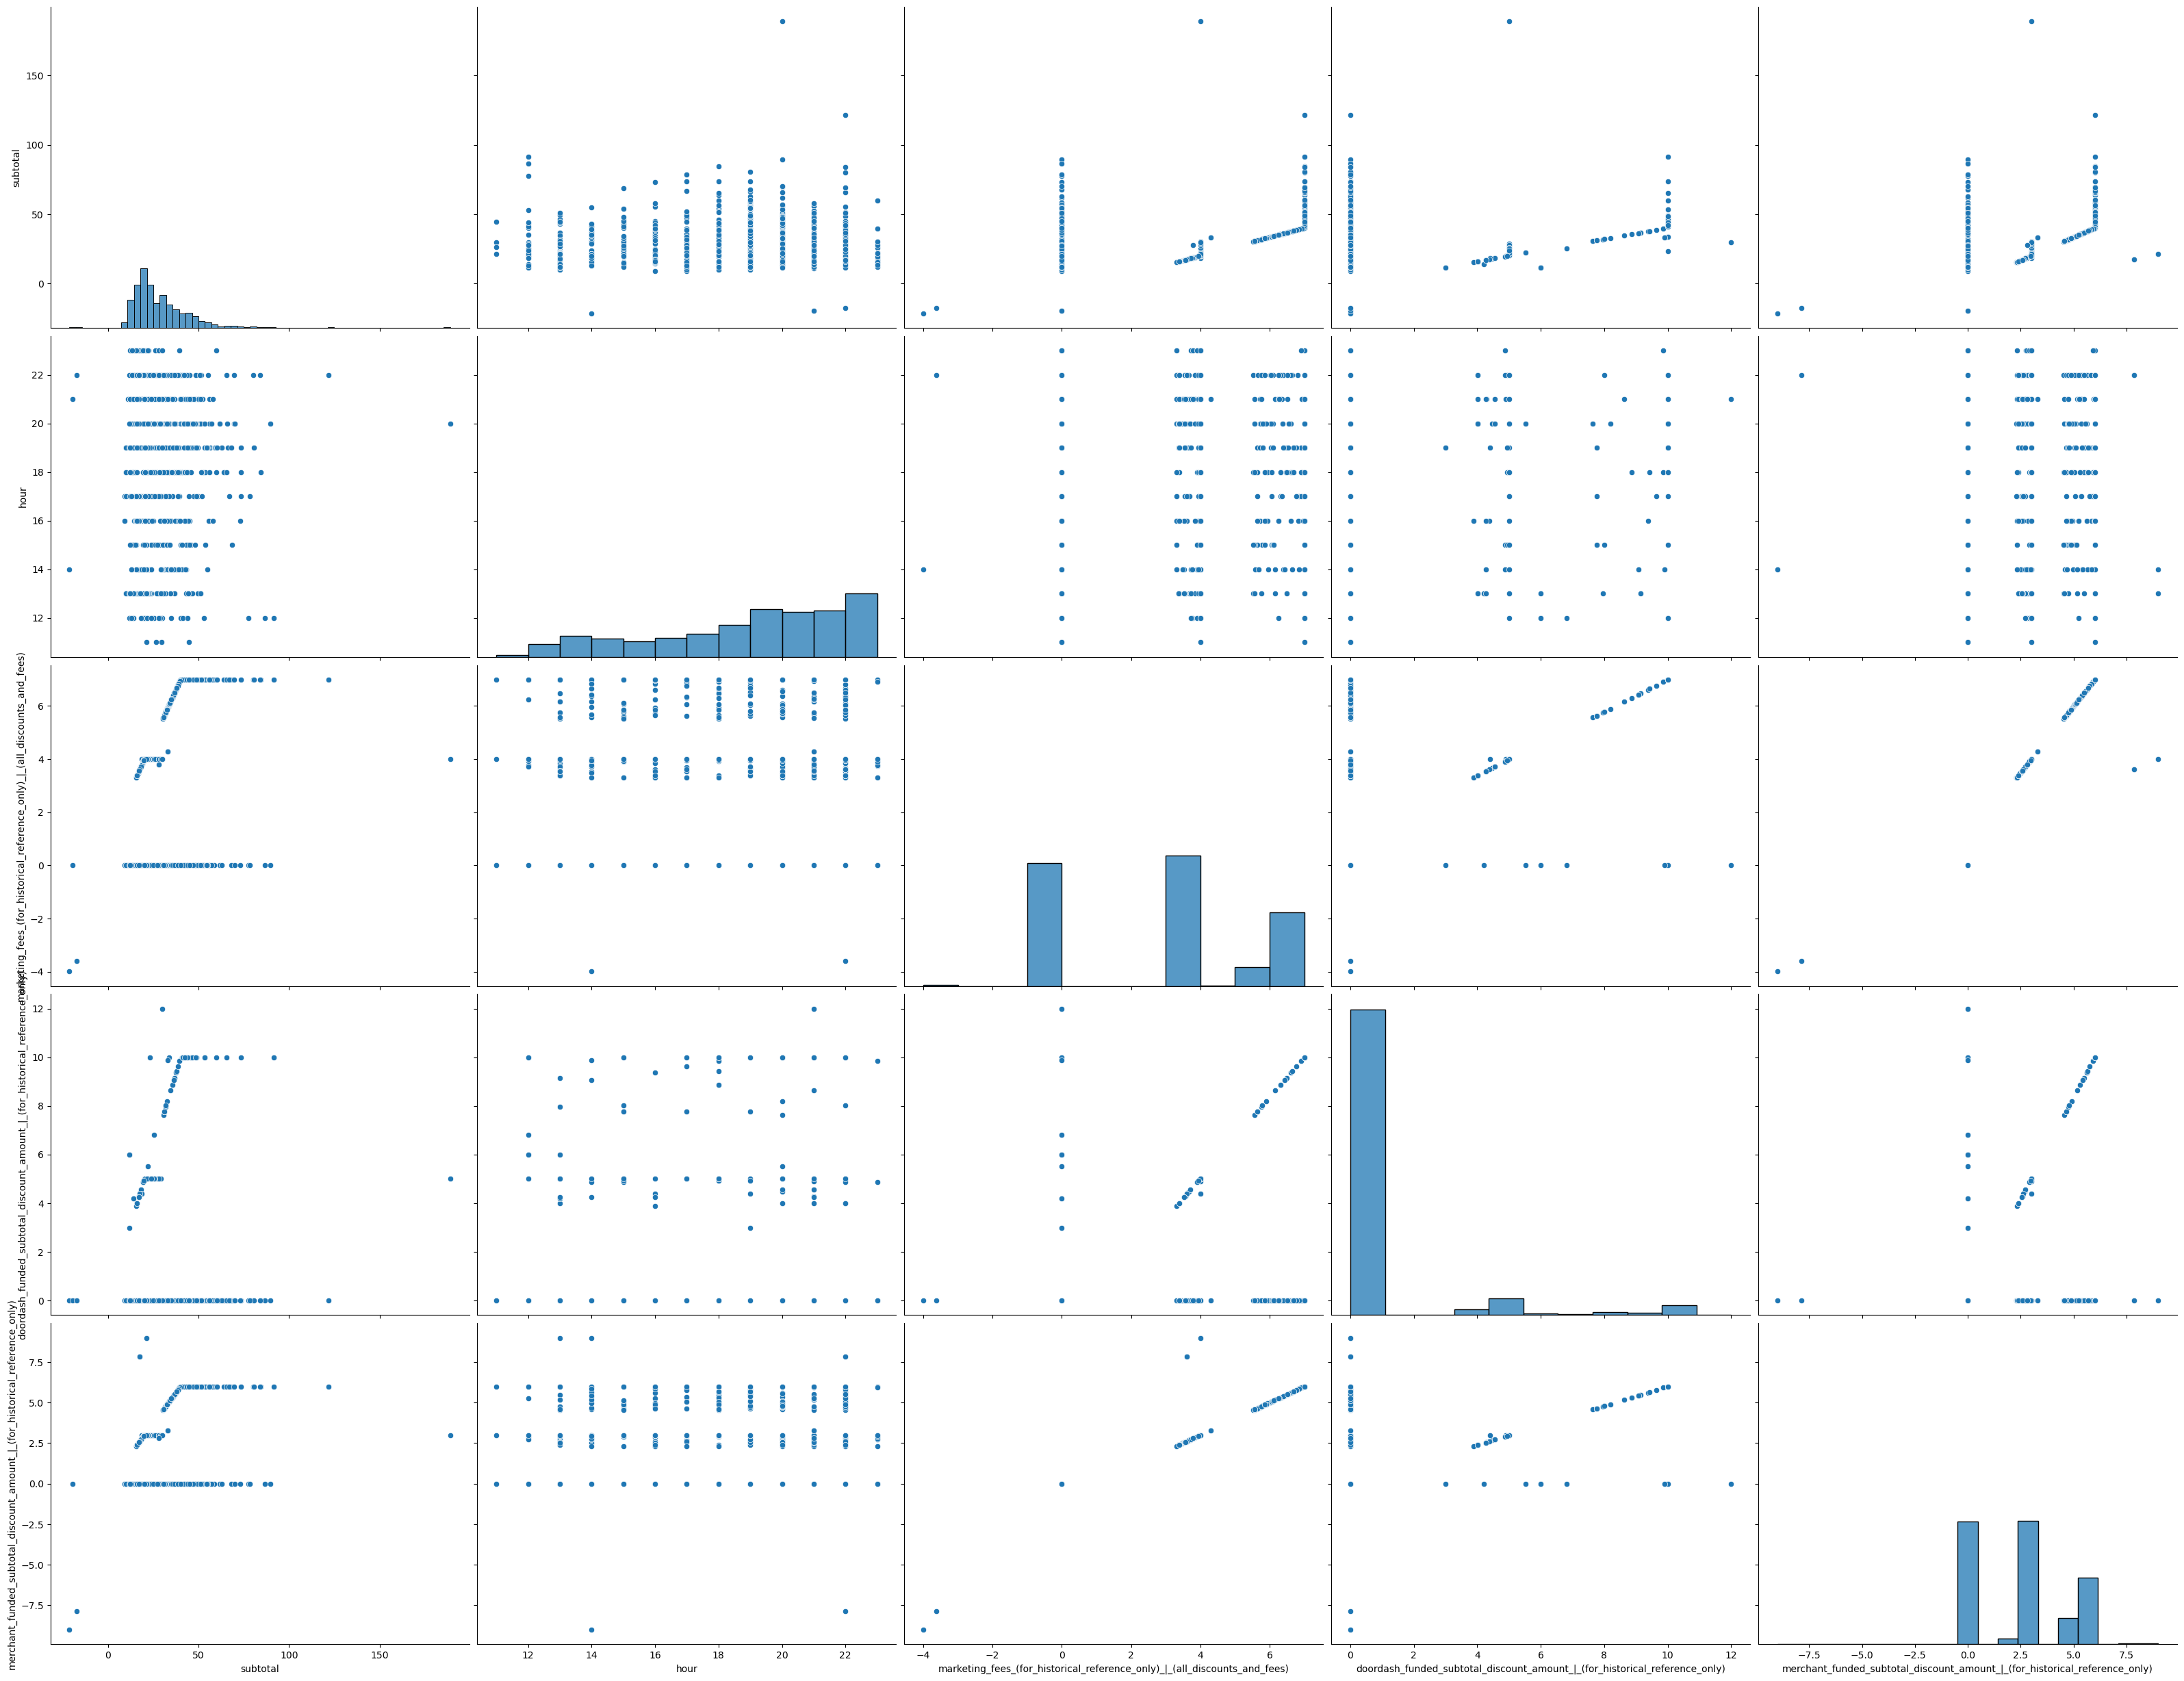

In [36]:
sns.pairplot(transaction_dat[transaction_dat.transaction_type == 'DEMANDGEN_DELIVERY'][['subtotal','hour','marketing_fees_(for_historical_reference_only)_|_(all_discounts_and_fees)','doordash_funded_subtotal_discount_amount_|_(for_historical_reference_only)','merchant_funded_subtotal_discount_amount_|_(for_historical_reference_only)']],height = 5, aspect = 1.3)


<Axes: xlabel='timestamp_local_date', ylabel='spent_amt'>

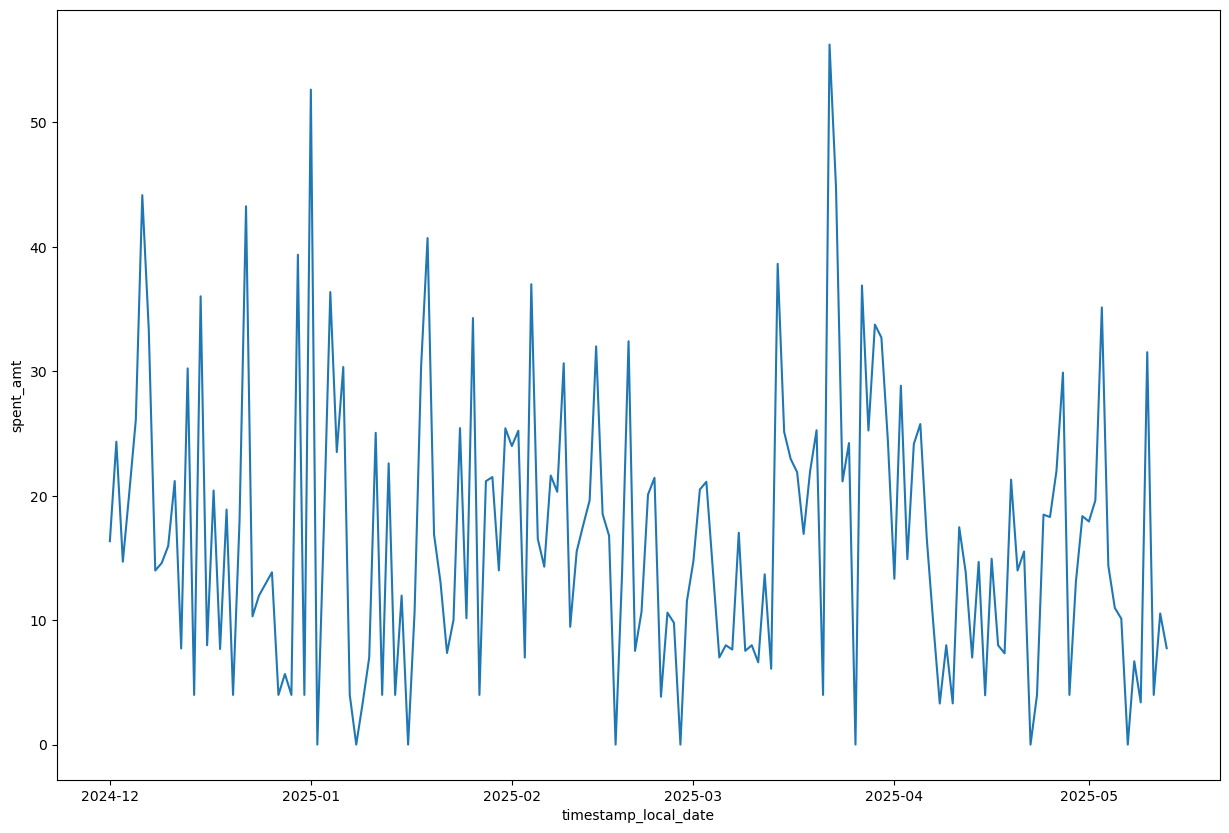

In [37]:
#monthly fees
total_fees = transaction_dat.groupby(['timestamp_local_date','transaction_type']).agg(sales = ('transaction_type','count'),spent_amt = ('marketing_fees_(for_historical_reference_only)_|_(all_discounts_and_fees)','sum')).reset_index()
total_fees[total_fees.transaction_type.str.contains("DEMAND")]

plt.figure(figsize = (15,10))
sns.lineplot(total_fees[total_fees.transaction_type.str.contains("DEMAND")],x = 'timestamp_local_date', y= 'spent_amt')



In [38]:
transaction_type_pt = pd.pivot_table(transaction_dat,index = 'timestamp_local_date', values = ['credit','subtotal'],columns='transaction_type' ,aggfunc='sum')
transaction_type_pt.sort_index()

credit                                      subtotal  \
transaction_type     AD_FEE DEMANDGEN_DELIVERY ERROR_CHARGE  FEE   AD_FEE   
timestamp_local_date                                                        
2024-12-01              NaN              83.84          NaN  0.0      NaN   
2024-12-02              NaN             124.32          NaN  NaN      NaN   
2024-12-03              0.0              87.25          NaN  NaN      0.0   
2024-12-04              0.0             109.71          NaN  NaN      0.0   
2024-12-05              0.0             167.27          NaN  NaN      0.0   
...                     ...                ...          ...  ...      ...   
2025-05-09              NaN              55.54          NaN  NaN      NaN   
2025-05-10              NaN             285.96          NaN  NaN      NaN   
2025-05-11              NaN             114.52          NaN  0.0      NaN   
2025-05-12              NaN              83.63          NaN  NaN      NaN   
2025-05-13              NaN             128.80          NaN  NaN      NaN   

                                                           
transaction_type     DEMANDGEN_DELIVERY ERROR_CHARGE  FEE  
timestamp_local_date                                       
2024-12-01                        89.20          NaN  0.0  
2024-12-02                       142.92          NaN  NaN  
2024-12-03                        94.88          NaN  NaN  
2024-12-04                       126.57          NaN  NaN  
2024-12-05                       182.81          NaN  NaN  
...                                 ...          ...  ...  
2025-05-09                        67.67          NaN  NaN  
2025-05-10                       301.52          NaN  NaN  
2025-05-11                       125.31          NaN  0.0  
2025-05-12                       106.33          NaN  NaN  
2025-05-13                       146.79          NaN  NaN  

[162 rows x 8 columns]

In [39]:
transaction_type_pt['cost_on_fees'] = transaction_type_pt[('subtotal','DEMANDGEN_DELIVERY')] - transaction_type_pt[('credit','DEMANDGEN_DELIVERY')]
transaction_type_pt

credit                                      subtotal  \
transaction_type     AD_FEE DEMANDGEN_DELIVERY ERROR_CHARGE  FEE   AD_FEE   
timestamp_local_date                                                        
2024-12-01              NaN              83.84          NaN  0.0      NaN   
2024-12-02              NaN             124.32          NaN  NaN      NaN   
2024-12-03              0.0              87.25          NaN  NaN      0.0   
2024-12-04              0.0             109.71          NaN  NaN      0.0   
2024-12-05              0.0             167.27          NaN  NaN      0.0   
...                     ...                ...          ...  ...      ...   
2025-05-09              NaN              55.54          NaN  NaN      NaN   
2025-05-10              NaN             285.96          NaN  NaN      NaN   
2025-05-11              NaN             114.52          NaN  0.0      NaN   
2025-05-12              NaN              83.63          NaN  NaN      NaN   
2025-05-13              NaN             128.80          NaN  NaN      NaN   

                                                          cost_on_fees  
transaction_type     DEMANDGEN_DELIVERY ERROR_CHARGE  FEE               
timestamp_local_date                                                    
2024-12-01                        89.20          NaN  0.0         5.36  
2024-12-02                       142.92          NaN  NaN        18.60  
2024-12-03                        94.88          NaN  NaN         7.63  
2024-12-04                       126.57          NaN  NaN        16.86  
2024-12-05                       182.81          NaN  NaN        15.54  
...                                 ...          ...  ...          ...  
2025-05-09                        67.67          NaN  NaN        12.13  
2025-05-10                       301.52          NaN  NaN        15.56  
2025-05-11                       125.31          NaN  0.0        10.79  
2025-05-12                       106.33          NaN  NaN        22.70  
2025-05-13                       146.79          NaN  NaN        17.99  

[162 rows x 9 columns]

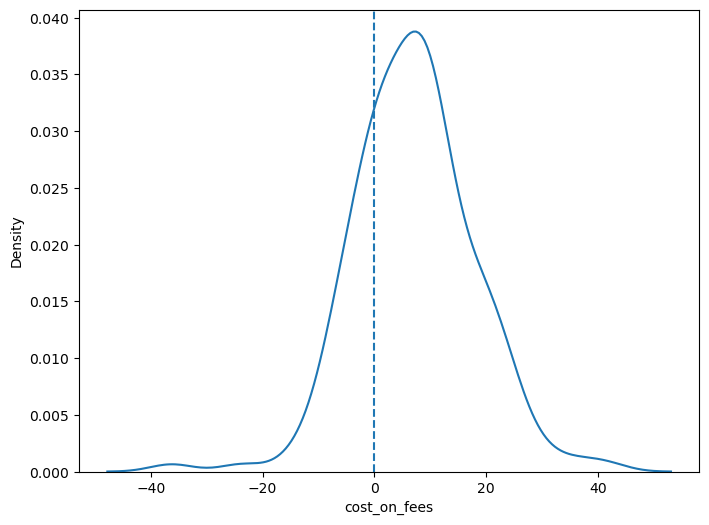

In [40]:
fig = plt.figure(figsize = (8,6))
g = sns.kdeplot(transaction_type_pt['cost_on_fees'])
g.axvline(x=0,linestyle = '--')
plt.show()


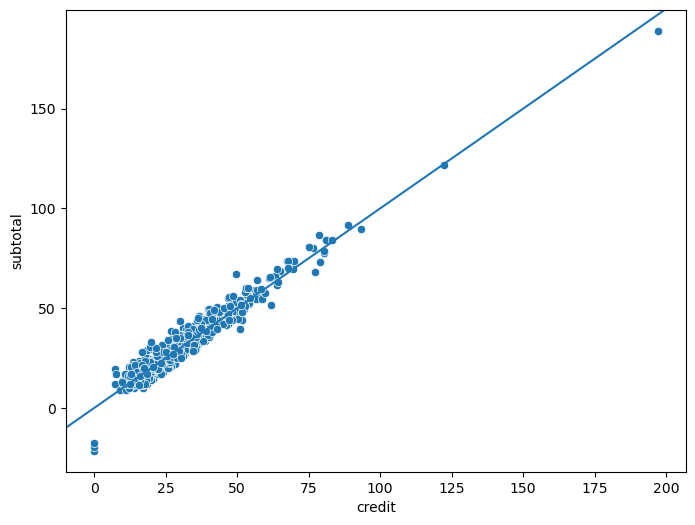

In [41]:
fig = plt.figure(figsize =(8,6))
g = sns.scatterplot(transaction_dat[transaction_dat['transaction_type'] == 'DEMANDGEN_DELIVERY'],x = 'credit', y = 'subtotal' )
g.axline(xy1=(0,0),xy2=(1,1))
plt.show()

In [42]:
transaction_dat['cost_on_fees'] = transaction_dat['subtotal'] - transaction_dat['credit']
transaction_dat[transaction_dat['transaction_type'] == 'DEMANDGEN_DELIVERY']['cost_on_fees'].describe()

count    858.000000
mean       1.334417
std        3.878265
min      -21.390000
25%       -1.097500
50%        1.440000
75%        3.990000
max       17.350000
Name: cost_on_fees, dtype: float64

<Axes: xlabel='cost_on_fees', ylabel='Density'>

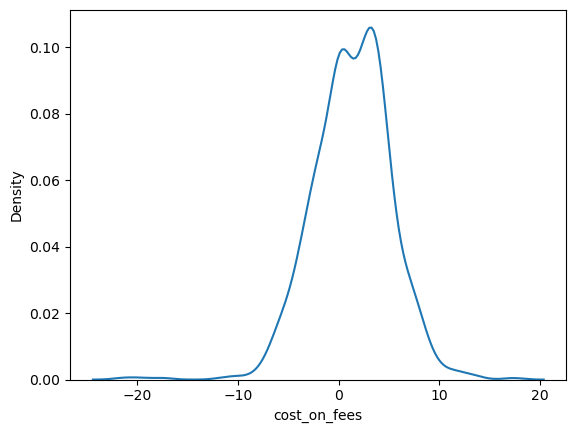

In [43]:
sns.kdeplot(transaction_dat[transaction_dat['transaction_type'] == 'DEMANDGEN_DELIVERY']['cost_on_fees'])

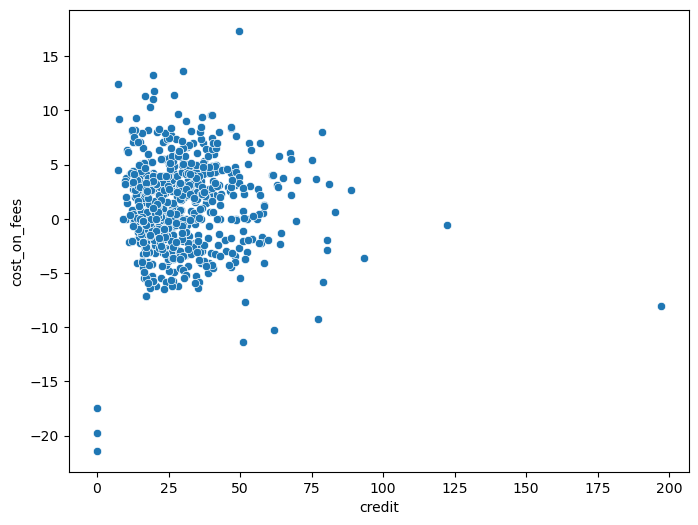

In [44]:
fig = plt.figure(figsize =(8,6))
g = sns.scatterplot(transaction_dat[transaction_dat['transaction_type'] == 'DEMANDGEN_DELIVERY'],x = 'credit', y = 'cost_on_fees' )
plt.show()

In [45]:
transaction_dat.final_order_status.value_counts()

final_order_status
Delivered                          1022
Picked Up                           133
Cancelled Long Fulfillment Time      22
Cancelled Paid                        3
Cancelled                             1
Name: count, dtype: int64

In [46]:
transaction_dat[transaction_dat['credit'] > 180][['ts_order','transaction_type','subtotal','credit','cost_on_fees','description']]['description'].values

array(['Order Received Time: 2025-01-11 17:04:36.680544000\nOrder Pickup Time: 2025-01-11 20:30:00.914000000'],
      dtype=object)

In [47]:
transaction_dat[['ts_order','description','subtotal'] ].values[0:5]

array([[Timestamp('2024-12-01 06:26:22'), 'Tablet fee', 0.0],
       [Timestamp('2024-12-01 15:09:52'),
        'Order Received Time: 2024-12-01 14:04:49.795104000\nOrder Pickup Time: 2024-12-01 15:09:51.000000000',
        31.98],
       [Timestamp('2024-12-01 16:19:31'),
        'Order Received Time: 2024-12-01 15:09:16.413505000\nOrder Pickup Time: 2024-12-01 16:19:30.000000000',
        37.48],
       [Timestamp('2024-12-01 18:04:25'),
        'Order Received Time: 2024-12-01 16:55:22.642157000\nOrder Pickup Time: 2024-12-01 18:04:24.000000000',
        19.74],
       [Timestamp('2024-12-02 13:58:55'),
        'Order Received Time: 2024-12-02 13:33:28.386026000\nOrder Pickup Time: 2024-12-02 13:58:54.798000000',
        15.99]], dtype=object)

## Final Notes

* Financials detailed transaction has order level data without Customer Information
* Description has ordered timestamp and pickeup timestamp. Cannot find delivery timestamp
* Are doordash drivers taking long to come?
